In [19]:
from ActiveLearning.dataHandling import MetricsSaver, getFirstEmptyFolder
from yamlParseObjects.yamlObjects import * 
from yamlParseObjects.variablesUtil import *
import logging
from shutil import copyfile
import subprocess
from ActiveLearning.benchmarks import DistanceFromCenter, Branin, Benchmark, Hosaki, SineFunc
from ActiveLearning.Sampling import *
import platform
import shutil
import matplotlib.pyplot as plt 
from enum import Enum
from sklearn import svm
from ActiveLearning.optimizationHelper import GA_Convergence_Sampler, GA_Exploiter, GA_Voronoi_Explorer, ResourceAllocator
from copy import copy, deepcopy

from ActiveLearning.visualization import *
import time 
from datetime import datetime 
import numpy as np 

Generating the samples using CVT method. This may take a while...
Output folder for figures:  ./assets/outputReports/105


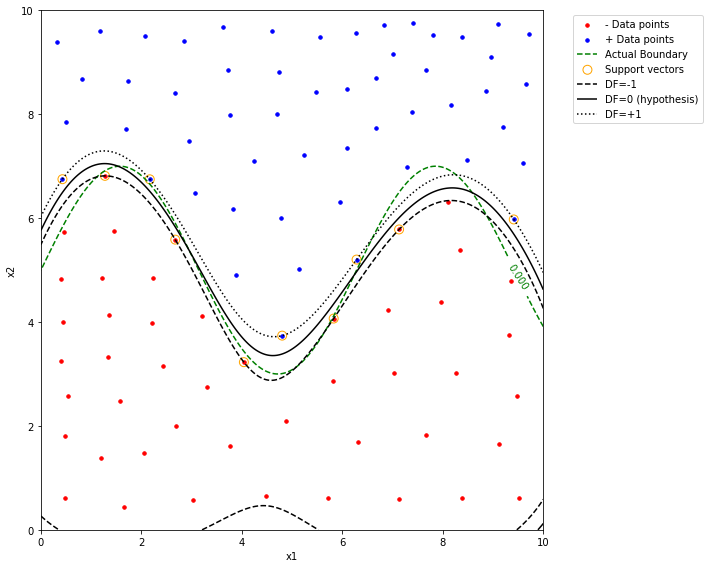

In [20]:

def constraint1(X):
    x1 = X[0]
    x2 = X[1]
    cons = x1-x2 < 2.5
    return cons

def constraint2(X):
    x2=X[1]
    cons = x2 < 3.5
    return cons
consVector = [constraint1, constraint2]

consVector = [] 


# Loading the config files of the process:
simConfigFile = './assets/yamlFiles/adaptiveTesting.yaml'
simConfig = simulationConfig(simConfigFile)
variableFiles = './assets/yamlFiles/varAdaptTest.yaml'
variables = getAllVariableConfigs(yamlFileAddress=variableFiles, scalingScheme=Scale.LINEAR)

# Loading the parameters of the process:
budget = simConfig.sampleBudget
batchSize = simConfig.batchSize
initialSampleSize = simConfig.initialSampleSize

mySpace = SampleSpace(variableList=variables)
dimNames = mySpace.getAllDimensionNames()
initialReport = IterationReport(dimNames)
# Defining the benchmark:
# myBench = DistanceFromCenter(threshold=1.5, inputDim=mySpace.dNum, center = [4] * mySpace.dNum)
# myBench = Branin(threshold=8)
# myBench = Hosaki(threshold = -1)
myBench = SineFunc(threshold=0)
# Generating the initial sample. This step is pure exploration MC sampling:

# Starting time:
initialReport.startTime = datetime.now()
initialReport.setStart()
initialSamples = generateInitialSample(space = mySpace, 
                                        sampleSize = initialSampleSize,
                                        method = InitialSampleMethod.CVT,
                                        checkForEmptiness=False,
                                        constraints=consVector,
                                        resample = True)
initialLabels = myBench.getLabelVec(initialSamples)


# Initial iteration of the classifier trained on the initial samples and their labels:
clf = StandardClassifier(kernel = 'rbf', C = 1000)
clf.fit(initialSamples, initialLabels)
# Adding the samples and their labels to the space: 
mySpace.addSamples(initialSamples, initialLabels)

# # Setting up the location of the output of the process:
outputFolder = f'{simConfig.outputFolder}/{getFirstEmptyFolder(simConfig.outputFolder)}'
# outputFolder = f'{simConfig.outputFolder}/{72}'
print('Output folder for figures: ', outputFolder)
copyfile(simConfigFile, f'{outputFolder}/{os.path.basename(simConfigFile)}')
iterationReportFile = f'{outputFolder}/iterationReport.yaml'
figFolder = setFigureFolder(outputFolder)
sInfo = SaveInformation(fileName = f'{figFolder}/0_InitialPlot', savePDF=True, savePNG=True)

# Visualization of the first iteration of the space with the initial sample:
meshRes = 300
figSize = (10,8)

plotSpace(mySpace, 
        classifier=clf, 
        figsize = figSize, 
        meshRes=meshRes,
        legend = True, 
        showPlot=False,
        saveInfo = sInfo, 
        benchmark = myBench,
        constraints = consVector)

In [21]:
initialReport.stopTime = datetime.now()
initialReport.setStop()
# Defining the exploiter: 
exploiter = GA_Exploiter(space = mySpace, 
                    epsilon = 0.05,
                    batchSize = simConfig.batchSize,
                    convergence_curve=False,
                    progress_bar=False,
                    clf = clf, 
                    constraints = consVector)

In [22]:
converger = GA_Convergence_Sampler(space = mySpace,
                    clf = clf,
                    batchSize = 1,
                    convergence_curve=False,
                    progress_bar=False,
                    constraints = consVector)

In [23]:
prevClf = clf 

In [24]:
exploiterPoints = exploiter.findNextPoints(pointNum=1)

 The best solution found:
 [8.81113888 6.34324349]

 Objective function:
 -0.07043868119043317


In [25]:
sv, label = converger.getFittingSupportVector()
print(sv,label)

[0.01093154 0.67704811] 0


In [9]:
sv

array([0.00164123, 0.72056921])

In [10]:
label

0

In [26]:
SVs = converger.clf.getSupportVectors(standard = True)

In [27]:
SVs

array([[7.12879567, 5.78283319],
       [1.27378701, 6.81453546],
       [5.82698178, 4.06712262],
       [2.67339231, 5.58674687],
       [4.03927257, 3.22757065],
       [6.28259667, 5.20256773],
       [0.42764562, 6.75009485],
       [2.16602438, 6.74804619],
       [4.80141958, 3.73854926],
       [9.41175419, 5.97524617]])

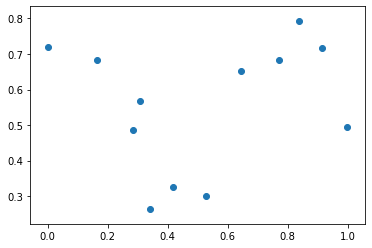

In [15]:
plt.scatter(SVs[:,0], SVs[:,1])

In [29]:
labels = converger.clf.predict(SVs)

In [30]:
labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [34]:
bestPoints = {}
for idx, sv in enumerate(SVs):
    svLabel = labels[idx]
    svDistance = converger._minDistanceFromOppositeClass(sv,svLabel)
    print(f'Found point for SV # {idx+1}: SV itself: {sv}, Distance: {svDistance}')
    bestPoints[svDistance] = (sv,idx)

Found point for SV # 1: SV itself: [7.12879567 5.78283319], Distance: 0.10260412983516654
Found point for SV # 2: SV itself: [1.27378701 6.81453546], Distance: 0.08485916843778146
Found point for SV # 3: SV itself: [5.82698178 4.06712262], Distance: 0.10769114590079534
Found point for SV # 4: SV itself: [2.67339231 5.58674687], Distance: 0.09868365268549234
Found point for SV # 5: SV itself: [4.03927257 3.22757065], Distance: 0.09175877079479151
Found point for SV # 6: SV itself: [6.28259667 5.20256773], Distance: 0.10260412983516654
Found point for SV # 7: SV itself: [0.42764562 6.75009485], Distance: 0.08485916843778145
Found point for SV # 8: SV itself: [2.16602438 6.74804619], Distance: 0.08947113227484066
Found point for SV # 9: SV itself: [4.80141958 3.73854926], Distance: 0.09175877079479157
Found point for SV # 10: SV itself: [9.41175419 5.97524617], Distance: 0.1179745989216249


In [35]:
bestDistance = max(bestPoints.keys())
bestDistance

0.1179745989216249

In [36]:
converger.R = bestDistance / 2
converger.R

0.05898729946081245

In [47]:
fittingSv, fittingIdx = bestPoints[bestDistance]
label = labels[fittingIdx]
converger.sv, converger.label = fittingSv, label

fittingSv, fittingIdx, label


(array([9.41175419, 5.97524617]), 9, 1)

In [48]:
def objFunction(X):
    df = converger.clf.decisionFunction(X.reshape(1,len(X)))
    f = df * label
    distance = np.linalg.norm(np.divide(X - converger.sv,converger.ranges),axis=1)
    if distance > converger.R or f > 0:
        f += 1e6
    return f    

In [49]:
gaModel = converger.getModel()

In [50]:
gaModel.run()

 The best solution found:
 [7.97212717 2.99869094]

 Objective function:
 999989.4459317501
